In [1]:
import rioxarray as rxr 
import geopandas as gpd
import xarray as xr
from shapely.geometry import box
from dask.distributed import LocalCluster,Client,performance_report,wait
import rasterio
from rasterio import crs, MemoryFile
from rasterio.vrt import WarpedVRT
from rasterio.shutil import copy as rio_copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
clust = LocalCluster(n_workers=6,threads_per_worker=2,dashboard_address=':8787')
cl = Client(clust)
cl

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 62.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33719,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 62.82 GiB
Comm: tcp://127.0.0.1:33410,Total threads: 2
Dashboard: http://127.0.0.1:41134/status,Memory: 10.47 GiB
Nanny: tcp://127.0.0.1:40723,


In [3]:
hcdn_boundaries = gpd.read_file('../data/geodata/basin_station_sntl.json').set_crs('32613',allow_override=True)

In [4]:
f = '/storage/dlhogan/sos/data/ucrb_ncld_land_cover.tif'
epsg_to = 32613
with rasterio.open(f) as src:
    print('Source CRS:' +str(src.crs))
    with WarpedVRT(src,resampling=1,src_crs=src.crs,crs=crs.CRS.from_epsg(epsg_to),warp_mem_limit=10000,warp_extras={'NUM_THREADS':2}) as vrt:
        print('Destination CRS:' +str(vrt.crs))
        ds = rxr.open_rasterio(vrt, masked=True).chunk({'x':256,'y':256,'band':1}).to_dataset(name='nlcd')


Source CRS:PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Destination CRS:EPSG:32613


In [5]:
# percent_area_trees_dict = {}
# for i,gage in enumerate(hcdn_boundaries.gage):
#     print(f'Working on {gage}...')
#     example = ds.rio.clip(hcdn_boundaries.geometry[i], drop=True).squeeze()['nlcd']
#     percent_area_trees = example.where(example.isin([41,42,43,52,90]),drop=True).compute()
#     percent_area_trees_dict[gage] = len(percent_area_trees.values.flatten()[~np.isnan(percent_area_trees.values.flatten())])/percent_area_trees.size

In [6]:
# percent_area_trees_array = pd.Series(percent_area_trees_dict.values(), index=percent_area_trees_dict.keys())

In [7]:
percent_area_trees_array = pd.read_csv('../data/geodata/basin_area_trees.csv', index_col=0).rename(columns={'0':'tree_area'})
percent_area_trees_array.index = ['0'+str(site) for site in percent_area_trees_array.index]
percent_area_trees_array_ds = percent_area_trees_array.to_xarray()
percent_area_trees_array_ds = percent_area_trees_array_ds.rename(index='site_no')
percent_area_trees_array_ds

<xarray.Dataset>
Dimensions:    (site_no: 29)
Coordinates:
  * site_no    (site_no) object '09034900' '09035900' ... '09378170' '09378630'
Data variables:
    tree_area  (site_no) float64 0.2375 0.3157 0.3858 ... 0.2666 0.5524 0.4876

In [8]:
# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')
# Drop bad basins
hcdn_daily_q = hcdn_daily_q.where(~hcdn_daily_q.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_annual_q = hcdn_annual_q.where(~hcdn_annual_q.site_no.isin(['09306242','09378170','09378630']),drop=True)

In [9]:
hcdn_annual_q = hcdn_annual_q.merge(percent_area_trees_array_ds).where(~hcdn_daily_q.site_no.isin(['09306242','09378170','09378630']),drop=True)

Text(0, 0.5, 'Basin Tree Cover Fraction')

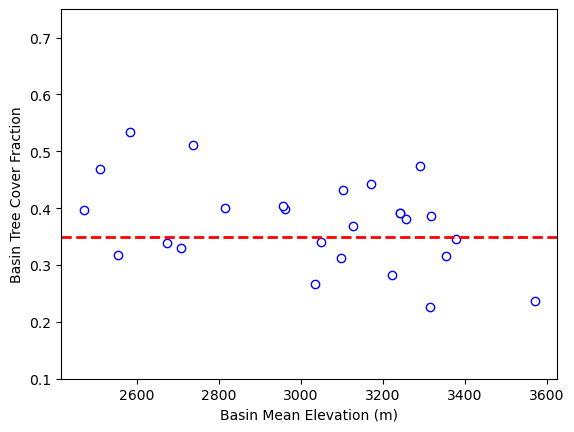

In [10]:
plt.scatter(hcdn_annual_q.elevation.mean(dim='year'),
            hcdn_annual_q.tree_area,
            ec='blue',
            facecolor='white')
plt.axhline(0.35, color='red', lw=2,ls='--')
plt.ylim(0.1,0.75)
plt.xlabel('Basin Mean Elevation (m)')
plt.ylabel('Basin Tree Cover Fraction')

Decided to use a thresholding metric of 35% tree covered area


In [11]:
low_tree_area_qmean = hcdn_annual_q.where(hcdn_annual_q.tree_area<0.35, drop=True)
high_tree_area_qmean = hcdn_annual_q.where(hcdn_annual_q.tree_area>=0.35, drop=True)

In [12]:
conf = 0.05

In [13]:
low_tree_qmean_ttest_results = pd.DataFrame(index=low_tree_area_qmean.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_tree_area_qmean.site_no.values:
    single_site_pre = low_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[:1999]
    single_site_post = low_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_tree_qmean_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_tree_qmean_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [14]:
low_tree_qmean_ttest_results


,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.257247,Probably Gaussian,0.074,Null Hypothesis Accepted,NaN,NaN
09035900,0.092024,Probably Gaussian,0.423,Null Hypothesis Accepted,NaN,NaN
09065500,0.179326,Probably Gaussian,0.094,Null Hypothesis Accepted,NaN,NaN
09081600,0.084546,Probably Gaussian,0.053,Null Hypothesis Accepted,NaN,NaN
09124500,0.036675,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.081,Null Hypothesis Accepted
09132500,0.030177,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.038,Null Hypothesis Rejected
09146200,0.787195,Probably Gaussian,0.066,Null Hypothesis Accepted,NaN,NaN
09183500,0.295278,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN
09239500,0.915084,Probably Gaussian,0.073,Null Hypothesis Accepted,NaN,NaN
09352900,0.161308,Probably Gaussian,0.024,Null Hypothesis Rejected,NaN,NaN


In [15]:
high_tree_qmean_ttest_results = pd.DataFrame(index=high_tree_area_qmean.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_tree_area_qmean.site_no.values:
    single_site_pre = high_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[:1999]
    single_site_post = high_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_tree_qmean_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_tree_qmean_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [16]:
high_tree_qmean_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09047700,0.00872,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.424,Null Hypothesis Accepted
09066000,0.377437,Probably Gaussian,0.151,Null Hypothesis Accepted,NaN,NaN
09066200,0.349053,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN
09066300,0.055656,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN
09107000,0.129873,Probably Gaussian,0.121,Null Hypothesis Accepted,NaN,NaN
09110000,0.096248,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09112500,0.377518,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN
09115500,0.185555,Probably Gaussian,0.107,Null Hypothesis Accepted,NaN,NaN
09119000,0.001538,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.03,Null Hypothesis Rejected
09147500,0.121565,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN


(0.0, 16.0)

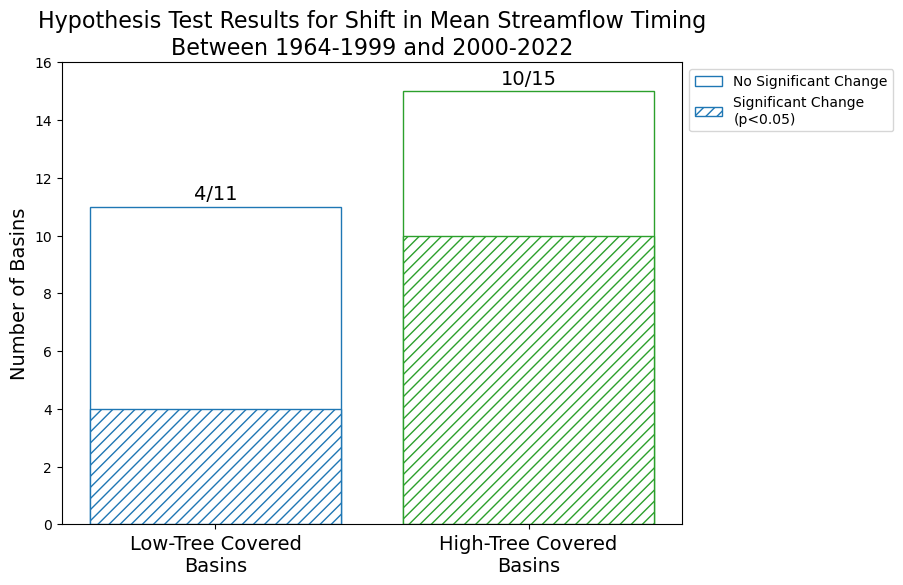

In [17]:
plt.style.use('default')
# create a dataframe with the results
low_rejected = len(low_tree_qmean_ttest_results[(low_tree_qmean_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_tree_qmean_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_tree_qmean_ttest_results[(high_tree_qmean_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_tree_qmean_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high Tree Covered sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Tree Covered\nBasins','High-Tree Covered\nBasins'], 
       height=[11,15], 
       ec=['#1f77b4','#2ca02c'], 
       color=['white', 'white'])
ax.bar(x=['Low-Tree Covered\nBasins','High-Tree Covered\nBasins'], 
       height=[(low_rejected), (high_rejected)], 
       ec=['#1f77b4','#2ca02c'], 
       color=['white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Shift in Mean Streamflow Timing\nBetween {1964}-1999 and 2000-2022', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=11.25, s=f'{low_rejected}/11', fontsize=14, ha='center')
ax.text(x=1, y=15.25, s=f'{high_rejected}/15', fontsize=14, ha='center')
ax.set_ylim(0,16)

### Setup to run clustering algorithm relating streamflow to tree cover area

In [18]:
# Make a tidy dataframe for clustering
tidy_df = hcdn_annual_q[['q_mm','tree_area','basin_area']].mean(dim='year').to_dataframe().reset_index()
q_tree_array = tidy_df[['q_mm','tree_area']].dropna().to_numpy()

In [19]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(q_tree_array)

In [21]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )

In [22]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [23]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

 # A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

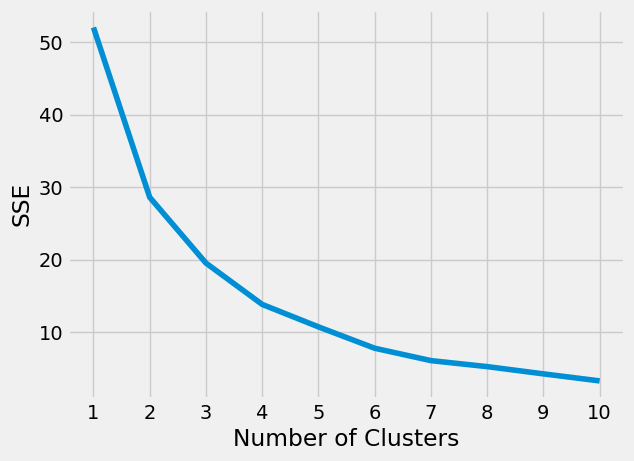

In [24]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [25]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
 )

kl.elbow

4

In [26]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

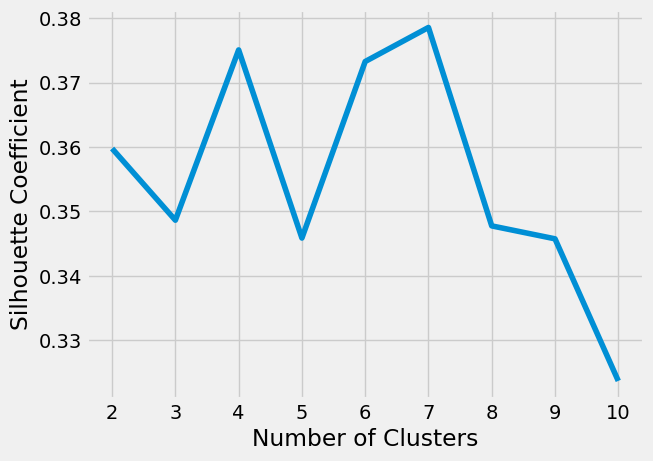

In [27]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [28]:
preprocessor = Pipeline(
     [
         ("scaler", MinMaxScaler()),
         ("pca", PCA(n_components=2, random_state=42)),
     ]
 )

In [29]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=2,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

In [30]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [31]:
pipe.fit(scaled_features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

In [32]:
preprocessed_data = pipe["preprocessor"].transform(scaled_features)

predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.37289183744016674

In [33]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(scaled_features),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

In [34]:
tiday_clustered_df = tidy_df.dropna().reset_index(drop=True).merge(pcadf['predicted_cluster'], left_index=True,right_index=True)

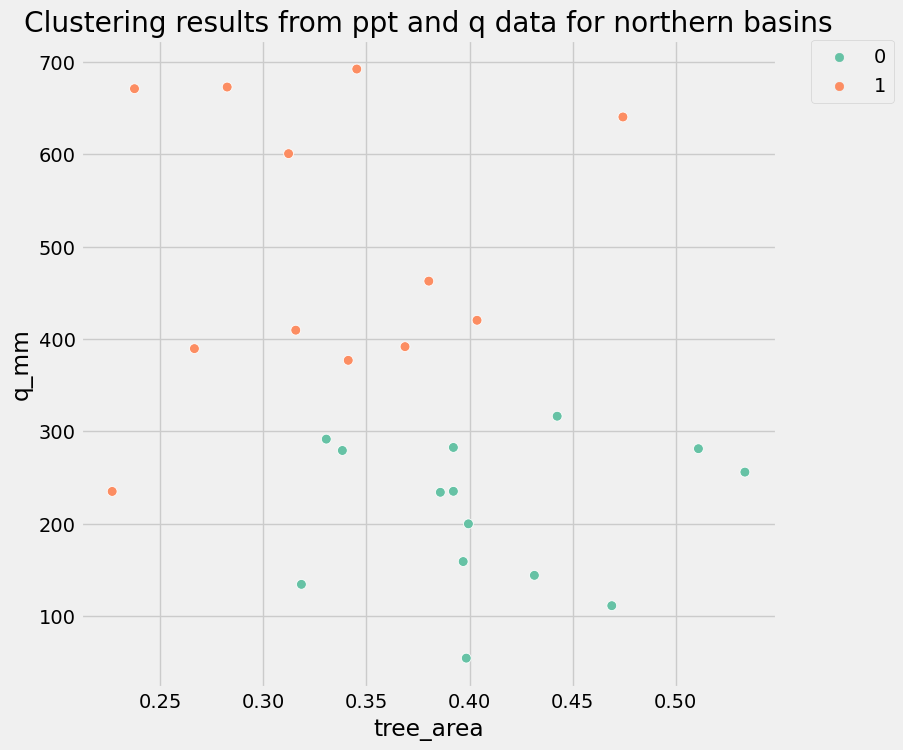

In [35]:
import seaborn as sns
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=tiday_clustered_df,
    x="tree_area",
    y="q_mm",
    s=50,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title(
    "Clustering results from ppt and q data for northern basins"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

Differentiate basins using clustering results

In [36]:
low_tree_area_qmean = hcdn_annual_q.sel(site_no=tiday_clustered_df[tiday_clustered_df['predicted_cluster']==1].site_no.to_list())
high_tree_area_qmean = hcdn_annual_q.sel(site_no=tiday_clustered_df[tiday_clustered_df['predicted_cluster']==0].site_no.to_list())

In [37]:
high_tree_area_qmean['tree_area'].mean()

<xarray.DataArray 'tree_area' ()>
array(0.40997436)

In [38]:
conf = 0.05

In [39]:
low_tree_qmean_ttest_results = pd.DataFrame(index=low_tree_area_qmean.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in low_tree_area_qmean.site_no.values:
    single_site_pre = low_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[:1999]
    single_site_post = low_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    low_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        low_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        low_tree_qmean_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            low_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            low_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        low_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        low_tree_qmean_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            low_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            low_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [40]:
low_tree_qmean_ttest_results


,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.257247,Probably Gaussian,0.074,Null Hypothesis Accepted,NaN,NaN
09035900,0.092024,Probably Gaussian,0.423,Null Hypothesis Accepted,NaN,NaN
09065500,0.179326,Probably Gaussian,0.094,Null Hypothesis Accepted,NaN,NaN
09066000,0.377437,Probably Gaussian,0.151,Null Hypothesis Accepted,NaN,NaN
09066200,0.349053,Probably Gaussian,0.028,Null Hypothesis Rejected,NaN,NaN
09081600,0.084546,Probably Gaussian,0.053,Null Hypothesis Accepted,NaN,NaN
09112500,0.377518,Probably Gaussian,0.01,Null Hypothesis Rejected,NaN,NaN
09124500,0.036675,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.081,Null Hypothesis Accepted
09146200,0.787195,Probably Gaussian,0.066,Null Hypothesis Accepted,NaN,NaN
09165000,0.026712,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.035,Null Hypothesis Rejected


In [41]:
high_tree_qmean_ttest_results = pd.DataFrame(index=high_tree_area_qmean.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in high_tree_area_qmean.site_no.values:
    single_site_pre = high_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[:1999]
    single_site_post = high_tree_area_qmean['q_mm'].sel(site_no=site).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    high_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        high_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        high_tree_qmean_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            high_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            high_tree_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        high_tree_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        high_tree_qmean_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            high_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            high_tree_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [42]:
high_tree_qmean_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09047700,0.00872,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.424,Null Hypothesis Accepted
09066300,0.055656,Probably Gaussian,0.034,Null Hypothesis Rejected,NaN,NaN
09107000,0.129873,Probably Gaussian,0.121,Null Hypothesis Accepted,NaN,NaN
09110000,0.096248,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09115500,0.185555,Probably Gaussian,0.107,Null Hypothesis Accepted,NaN,NaN
09119000,0.001538,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.03,Null Hypothesis Rejected
09132500,0.030177,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.038,Null Hypothesis Rejected
09147500,0.121565,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN
09183500,0.295278,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN
09210500,0.055539,Probably Gaussian,0.221,Null Hypothesis Accepted,NaN,NaN


(0.0, 15.0)

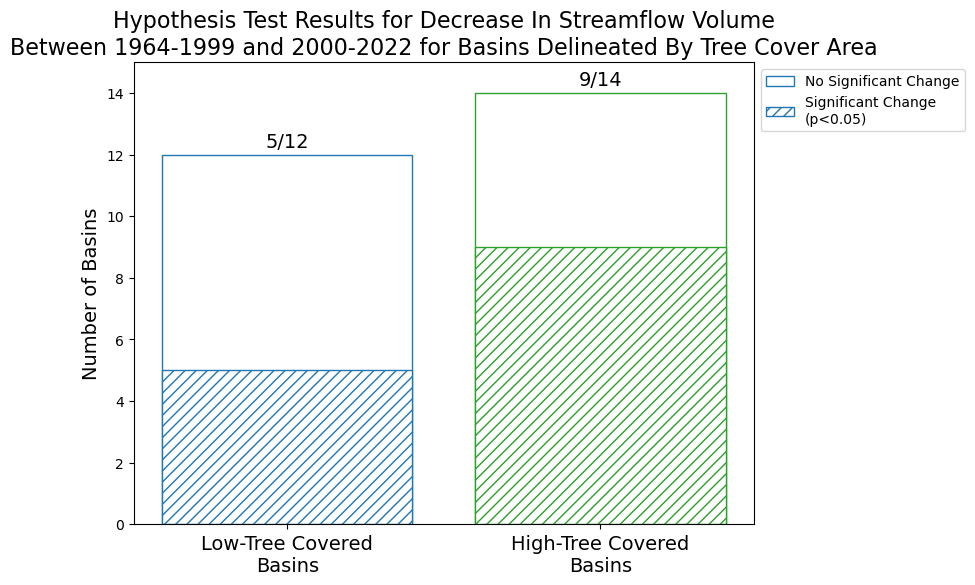

In [43]:
plt.style.use('default')
# create a dataframe with the results
low_rejected = len(low_tree_qmean_ttest_results[(low_tree_qmean_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_tree_qmean_ttest_results['mannwhitney p']<0.05)])
high_rejected = len(high_tree_qmean_ttest_results[(high_tree_qmean_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_tree_qmean_ttest_results['mannwhitney p']<0.05)])
# create a stacked bar chart with low, mid, and high Tree Covered sites
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x=['Low-Tree Covered\nBasins','High-Tree Covered\nBasins'], 
       height=[12,14], 
       ec=['#1f77b4','#2ca02c'], 
       color=['white', 'white'])
ax.bar(x=['Low-Tree Covered\nBasins','High-Tree Covered\nBasins'], 
       height=[(low_rejected), (high_rejected)], 
       ec=['#1f77b4','#2ca02c'], 
       color=['white', 'white'], 
       hatch='///')
# add a legend with the hatch pattern
ax.legend(['No Significant Change','Significant Change\n(p<0.05)'], loc='upper left', bbox_to_anchor=(1,1))
# add y-label for number of basins
ax.set_ylabel('Number of Basins', fontsize=14)
# add title
ax.set_title(f'Hypothesis Test Results for Decrease In Streamflow Volume\nBetween {1964}-1999 and 2000-2022 for Basins Delineated By Tree Cover Area', fontsize=16)
# increase the font-size of the x-aixs tick labels
ax.tick_params(axis='x', labelsize=14)
# add text to the bars with the number of rejected values in each category over the number of basins in each category
ax.text(x=0, y=12.25, s=f'{low_rejected}/12', fontsize=14, ha='center')
ax.text(x=1, y=14.25, s=f'{high_rejected}/14', fontsize=14, ha='center')
ax.set_ylim(0,15)

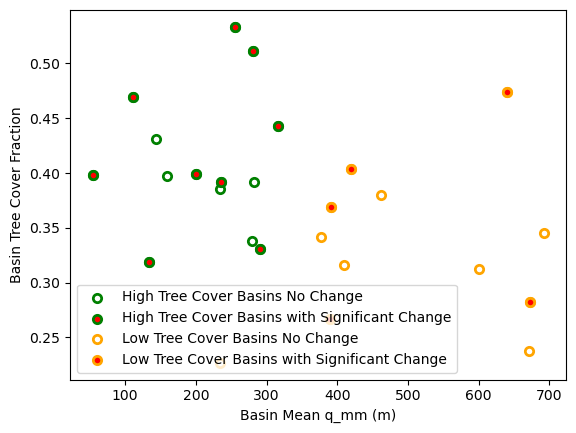

In [46]:
plt.scatter(hcdn_annual_q.sel(site_no=tiday_clustered_df[tiday_clustered_df['predicted_cluster']==0]['site_no'].to_list()).q_mm.mean(dim='year'),
            hcdn_annual_q.sel(site_no=tiday_clustered_df[tiday_clustered_df['predicted_cluster']==0]['site_no'].to_list()).tree_area,
            ec='green',
            facecolor='white',
            lw=2,
            label='High Tree Cover Basins No Change')
high_rejected_basins = high_tree_qmean_ttest_results[(high_tree_qmean_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (high_tree_qmean_ttest_results['mannwhitney p']<0.05)].index.to_list()
plt.scatter(hcdn_annual_q.sel(site_no=high_rejected_basins).q_mm.mean(dim='year'),
            hcdn_annual_q.sel(site_no=high_rejected_basins).tree_area,
            ec='green',
            lw=2,
            facecolor='red',
            label='High Tree Cover Basins with Significant Change')

plt.scatter(hcdn_annual_q.sel(site_no=tiday_clustered_df[tiday_clustered_df['predicted_cluster']==1]['site_no'].to_list()).q_mm.mean(dim='year'),
            hcdn_annual_q.sel(site_no=tiday_clustered_df[tiday_clustered_df['predicted_cluster']==1]['site_no'].to_list()).tree_area,
            ec='orange',
            facecolor='white',
            lw=2,
            label='Low Tree Cover Basins No Change')
low_rejected_basins = low_tree_qmean_ttest_results[(low_tree_qmean_ttest_results['t-test Result']=='Null Hypothesis Rejected') | 
                                         (low_tree_qmean_ttest_results['mannwhitney p']<0.05)].index.to_list()
plt.scatter(hcdn_annual_q.sel(site_no=low_rejected_basins).q_mm.mean(dim='year'),
            hcdn_annual_q.sel(site_no=low_rejected_basins).tree_area,
            ec='orange',
            lw=2,
            facecolor='red',
            label='Low Tree Cover Basins with Significant Change')
# plt.axhline(0.35, color='red', lw=2,ls='--')
# plt.ylim(0.1,0.6)
plt.xlabel('Basin Mean q_mm (m)')
plt.ylabel('Basin Tree Cover Fraction')
plt.legend()




In [46]:
tiday_clustered_df[tiday_clustered_df['predicted_cluster']==0]['site_no'].to_list()

['09047700',
 '09066300',
 '09107000',
 '09110000',
 '09115500',
 '09119000',
 '09132500',
 '09147500',
 '09183500',
 '09210500',
 '09223000',
 '09239500',
 '09304500',
 '09312600']